# `l2hmc-qcd`

This notebook contains a minimal working example for the 4D SU(3) Model

Uses `torch.complex128` by default

## Setup

In [1]:
! nvidia-smi | tail --lines -7

+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A    158427      C   ...nvs/2022-07-01/bin/python    11643MiB |
+-----------------------------------------------------------------------------+


In [2]:
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2

import os
# --------------------------------------
# BE SURE TO GRAB A FRESH GPU !
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
!echo $CUDA_VISIBLE_DEVICES
# --------------------------------------

2


In [3]:
devices = os.environ.get('CUDA_VISIBLE_DEVICES', None)
print(devices)
!getconf _NPROCESSORS_ONLN

2
256


In [4]:
from __future__ import absolute_import, print_function, annotations, division

import warnings
import logging

import torch
import numpy as np

warnings.filterwarnings('ignore')

os.environ['MASTER_PORT'] = '12345'
os.environ['OMP_NUM_THREADS'] = '256'

from l2hmc.utils.dist import (
    setup_torch
)

_ = setup_torch(
    precision='float64',
    backend='DDP',
    seed=1234,
)

from hydra.core.global_hydra import GlobalHydra

np.set_printoptions(threshold=5)
torch.set_printoptions(threshold=5, precision=5)

from rich.logging import RichHandler
from rich.style import Style
from rich.console import Console
from rich.logging import RichHandler
from l2hmc.utils.rich import get_console

console = get_console(width=120)
log = logging.getLogger()
handler = RichHandler(
    rich_tracebacks=True,
    tracebacks_show_locals=True,
    console=console,
    show_path=False,
    log_time_format='[%H:%m:%S]',
    enable_link_path=False,
)

log.handlers = [handler]

log.setLevel('INFO')

tlog = logging.getLogger('torch')
tlog.setLevel('ERROR')

wblog = logging.getLogger('wandb')
wblog.setLevel('CRITICAL')

--------------------------------------------------------------------------

  Local host:   thetagpu24
  Local device: mlx5_0
--------------------------------------------------------------------------


In [5]:
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment

import l2hmc.group.su3.pytorch.group as gpt
ptsu3 = gpt.SU3()

import l2hmc
l2hmc.__file__

'/lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/__init__.py'

## Specify defaults for building Experiment

In [6]:
GlobalHydra.instance().clear()

defaults_su3 = [
    'steps.nera=1',
    'steps.nepoch=10',
    'steps.test=50',
    'steps.print=1',
    'steps.log=1',
    # ------------------------------
    'conv=none',
    'network.activation_fn=tanh',
    'network.dropout_prob=0.0',
    'network.units=[8, 8]',
    # ------------------------------
    'learning_rate.lr_init=0.001',
    # ------------------------------
    'dynamics.group=SU3',
    'dynamics.eps=0.125',
    'dynamics.nchains=4',
    'dynamics.nleapfrog=16',
    'dynamics.verbose=True',
    'dynamics.latvolume=[8, 8, 8, 12]',
    'dynamics.eps_fixed=false',
    # ------------------------------
    'net_weights.x.s=0.0',
    'net_weights.x.q=0.0',
    'net_weights.x.t=0.0',
    # ------------------------------
    'loss.charge_weight=0.0',
    'loss.plaq_weight=1.0',
    # ------------------------------
    'annealing_schedule.beta_init=6.0',
    'annealing_schedule.beta_final=6.0',
    #'net_weights.x.t=0.0',
    #'net_weights.x.q=0.0',
    # ------------------------------
]

In [7]:
import gc
import GPUtil

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
torch.clear_autocast_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 27% | 14% |
|  1 |  0% |  0% |
|  2 |  0% |  1% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


## Build Experiment

In [10]:
from l2hmc.configs import get_experiment

GlobalHydra.instance().clear()

ptExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=pytorch',
        'backend=DDP',
        'init_wandb=False',
        'init_aim=False',
        'learning_rate.clip_norm=10',
        'restore=false',
        'save=false',
    ],
    build_networks=True,
)

[00:02:36] INFO     Caught MASTER_PORT:12345 from environment!

[00:02:37] INFO     Caught MASTER_PORT:12345 from environment!

[00:02:39] WARNING  Using `torch.optim.SGD` optimizer

## Train

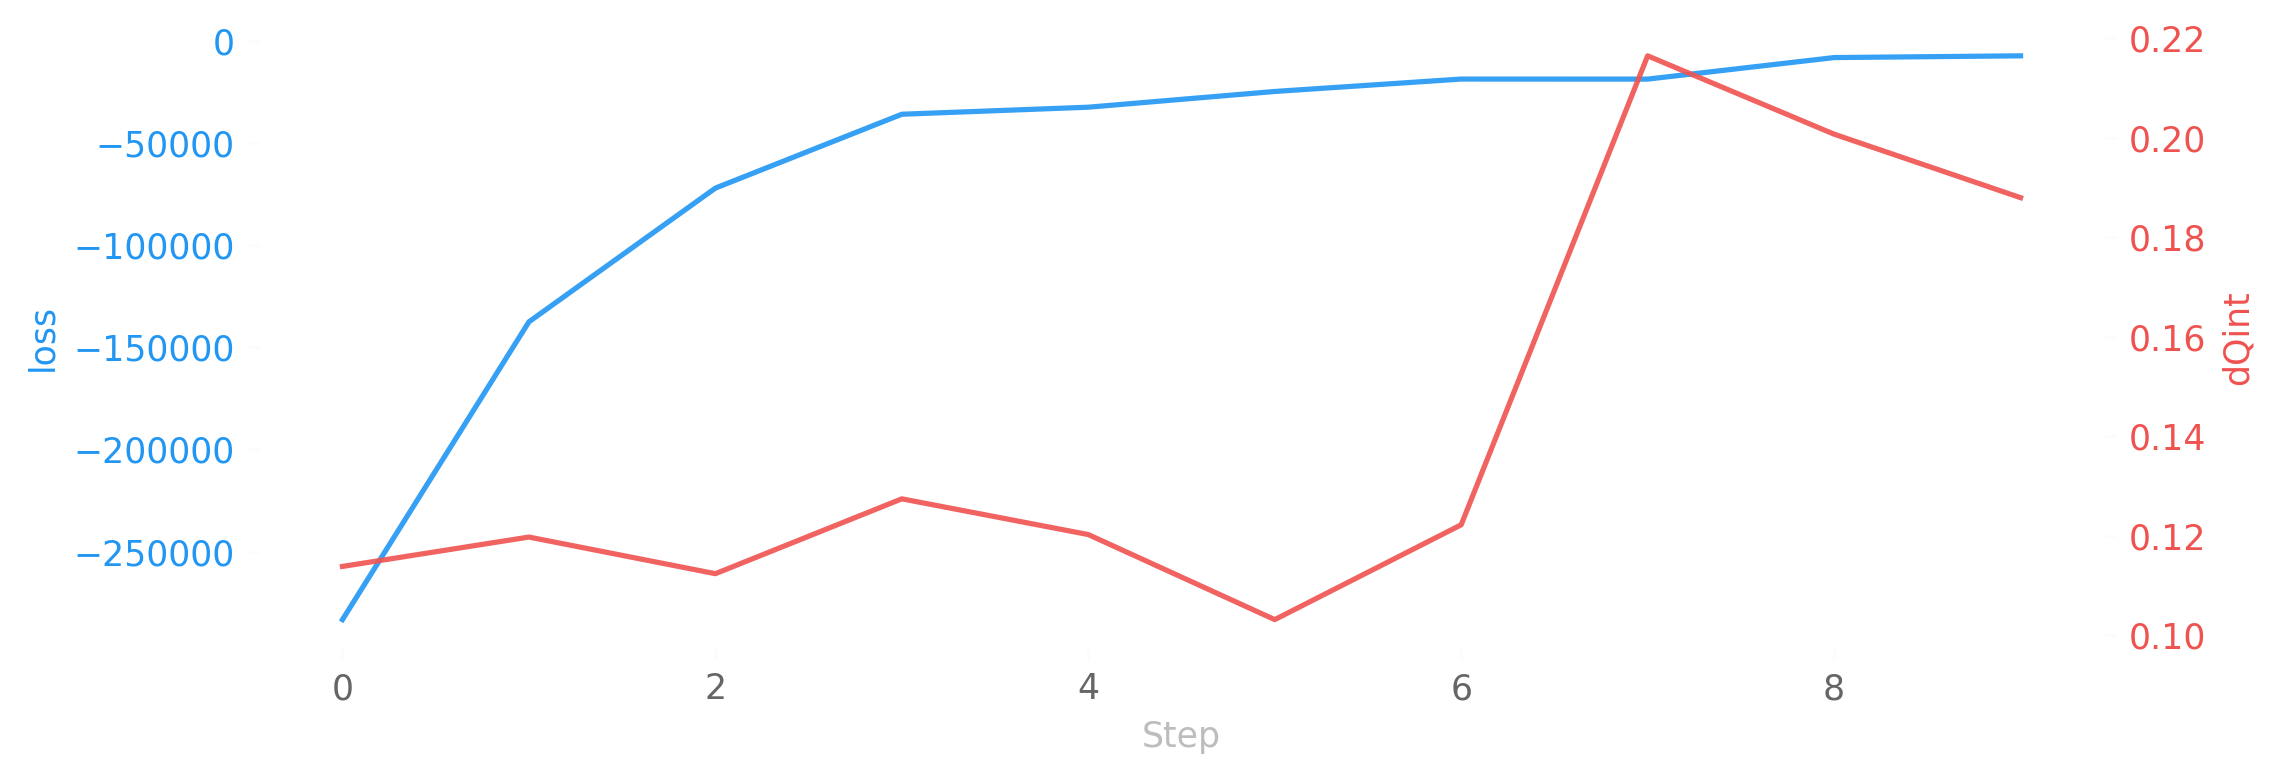

[00:02:29] INFO     [TRAINING] x.dtype: torch.complex128

           INFO     [TRAINING] self._dtype: torch.float64

           INFO     ┏━━━━━━━━━━━━━━━━━━━━━━━━━┓

           INFO     ┃ ERA: 0 / 1, BETA: 6.000 ┃

           INFO     ┗━━━━━━━━━━━━━━━━━━━━━━━━━┛

[00:02:07] INFO     Thermalizing configs @ 6.00 took 217.9737 s

Training:   0%|          | 0/10 [00:00<?, ?it/s]

           WARNING  [TRAINING] x.dtype: torch.complex128

           WARNING  [TRAINING] x.device: cuda:0

[00:02:37] INFO     era=0   epoch=0   tstep=1   dt=54.3324 beta=6.0000 loss=-283224.5067 dQsin=0.0003 dQint=0.1138      
                    energy=-124991.5350 logprob=-2752405.7597 logdet=2627414.2247 sldf=2627419.8798 sldb=-5.6551        
                    sldfb=2627414.2247 sld=2627414.2247 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538968.4197       
                    acc_mask=1.0000 plaqs=0.5945 sinQ=-0.0000 intQ=-0.0053 lr=0.0010

[00:02:05] INFO     era=0   epoch=1   tstep=2   dt=54.5740 beta=6.0000 loss=-137551.9300 dQsin=0.0003 dQint=0.1197      
                    energy=-118562.0067 logprob=-2745972.1074 logdet=2627410.1007 sldf=2627429.4629 sldb=-19.3622       
                    sldfb=2627410.1007 sld=2627410.1007 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538932.4855       
                    acc_mask=1.0000 plaqs=0.5657 sinQ=-0.0002 intQ=-0.0609 lr=0.0010

[00:02:31] INFO     era=0   epoch=2   tstep=3   dt=52.7563 beta=6.0000 loss=-72140.1336 dQsin=0.0003 dQint=0.1123       
                    energy=-114206.5999 logprob=-2741608.7433 logdet=2627402.1434 sldf=2627422.1845 sldb=-20.0411       
                    sldfb=2627402.1434 sld=2627402.1434 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538940.4237       
                    acc_mask=1.0000 plaqs=0.5458 sinQ=0.0000 intQ=0.0073 lr=0.0010

[00:02:01] INFO     era=0   epoch=3   tstep=4   dt=53.1144 beta=6.0000 loss=-36001.4838 dQsin=0.0004 dQint=0.1274       
                    energy=-111248.6870 logprob=-2738631.2312 logdet=2627382.5441 sldf=2627399.0318 sldb=-16.4877       
                    sldfb=2627382.5441 sld=2627382.5441 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538913.5751       
                    acc_mask=1.0000 plaqs=0.5318 sinQ=0.0003 intQ=0.1016 lr=0.0010

[00:02:31] INFO     era=0   epoch=4   tstep=5   dt=54.0702 beta=6.0000 loss=-32557.3034 dQsin=0.0003 dQint=0.1202       
                    energy=-109562.5056 logprob=-2736975.9266 logdet=2627413.4210 sldf=2627426.3051 sldb=-12.8841       
                    sldfb=2627413.4210 sld=2627413.4210 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538952.9111       
                    acc_mask=1.0000 plaqs=0.5225 sinQ=-0.0001 intQ=-0.0258 lr=0.0010

[00:02:58] INFO     era=0   epoch=5   tstep=6   dt=52.1106 beta=6.0000 loss=-24863.1679 dQsin=0.0003 dQint=0.1031       
                    energy=-107137.4223 logprob=-2734561.8770 logdet=2627424.4547 sldf=2627440.9476 sldb=-16.4929       
                    sldfb=2627424.4547 sld=2627424.4547 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538964.5796       
                    acc_mask=1.0000 plaqs=0.5133 sinQ=0.0002 intQ=0.0816 lr=0.0010

[00:02:25] INFO     era=0   epoch=6   tstep=7   dt=50.5436 beta=6.0000 loss=-18792.4677 dQsin=0.0003 dQint=0.1222       
                    energy=-105551.1433 logprob=-2732966.9708 logdet=2627415.8275 sldf=2627431.5058 sldb=-15.6783       
                    sldfb=2627415.8275 sld=2627415.8275 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538948.6684       
                    acc_mask=1.0000 plaqs=0.5058 sinQ=0.0001 intQ=0.0520 lr=0.0010

[00:02:48] INFO     era=0   epoch=7   tstep=8   dt=49.7256 beta=6.0000 loss=-18812.8190 dQsin=0.0006 dQint=0.2165       
                    energy=-103779.3362 logprob=-2731190.1706 logdet=2627410.8344 sldf=2627425.4196 sldb=-14.5851       
                    sldfb=2627410.8344 sld=2627410.8344 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538940.0197       
                    acc_mask=1.0000 plaqs=0.4995 sinQ=0.0003 intQ=0.1127 lr=0.0010

[00:02:10] INFO     era=0   epoch=8   tstep=9   dt=48.7695 beta=6.0000 loss=-8281.7503 dQsin=0.0006 dQint=0.2007        
                    energy=-102749.7400 logprob=-2730155.5664 logdet=2627405.8264 sldf=2627424.2317 sldb=-18.4053       
                    sldfb=2627405.8264 sld=2627405.8264 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538938.0897       
                    acc_mask=1.0000 plaqs=0.4933 sinQ=-0.0001 intQ=-0.0408 lr=0.0010

[00:02:32] INFO     era=0   epoch=9   tstep=10  dt=48.9984 beta=6.0000 loss=-7426.7467 dQsin=0.0005 dQint=0.1880        
                    energy=-101939.5648 logprob=-2729342.8843 logdet=2627403.3195 sldf=2627422.0550 sldb=-18.7354       
                    sldfb=2627403.3195 sld=2627403.3195 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538926.3720       
                    acc_mask=1.0000 plaqs=0.4900 sinQ=0.0004 intQ=0.1227 lr=0.0010

           INFO     Training took: 1684.4206

[00:02:37] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-02-20-000036/pytorch/train/plots/ridgeplots/svgs/energy_ridgeplot.svg

[00:02:39] INFO     Ridgeplot for energy took 5.358s

[00:02:41] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-02-20-000036/pytorch/train/plots/ridgeplots/svgs/logprob_ridgeplot.svg

[00:02:43] INFO     Ridgeplot for logprob took 4.520s

[00:02:46] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-02-20-000036/pytorch/train/plots/ridgeplots/svgs/logdet_ridgeplot.svg

[00:02:49] INFO     Ridgeplot for logdet took 5.442s

[00:02:51] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-02-20-000036/pytorch/train/plots/ridgeplots/svgs/sldf_ridgeplot.svg

[00:02:53] INFO     Ridgeplot for sldf took 4.291s

[00:02:55] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-02-20-000036/pytorch/train/plots/ridgeplots/svgs/sldb_ridgeplot.svg

[00:02:57] INFO     Ridgeplot for sldb took 4.049s

[00:02:00] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-02-20-000036/pytorch/train/plots/ridgeplots/svgs/sldfb_ridgeplot.svg

[00:02:02] INFO     Ridgeplot for sldfb took 4.666s

[00:02:04] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-02-20-000036/pytorch/train/plots/ridgeplots/svgs/sld_ridgeplot.svg

[00:02:06] INFO     Ridgeplot for sld took 4.747s

[00:02:18] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-02-20-000036/pytorch/train/data/train_data.h5

[00:02:19] INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

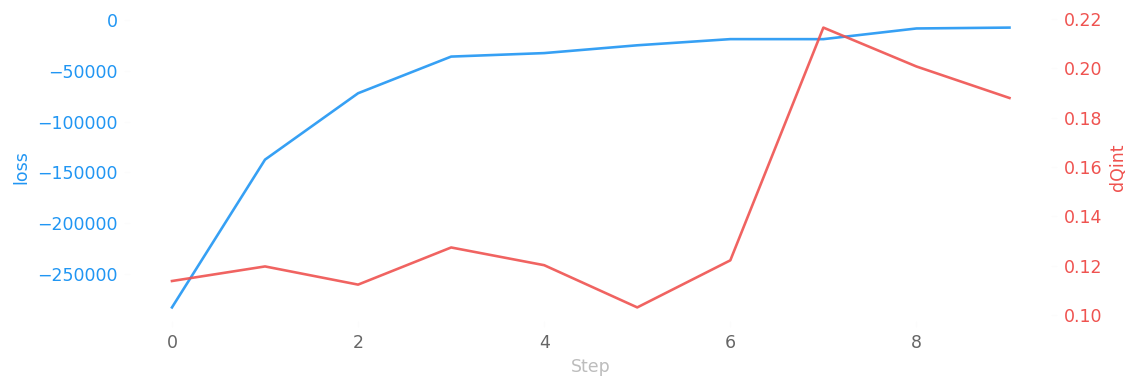

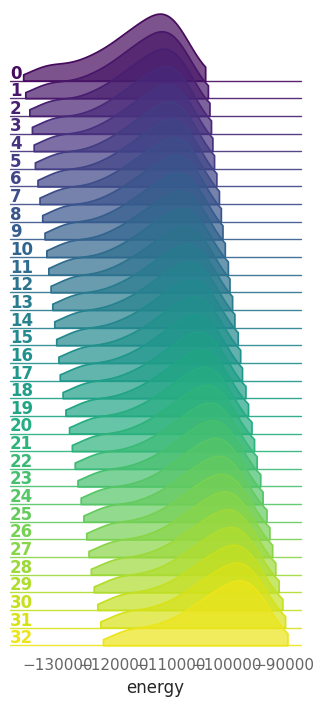

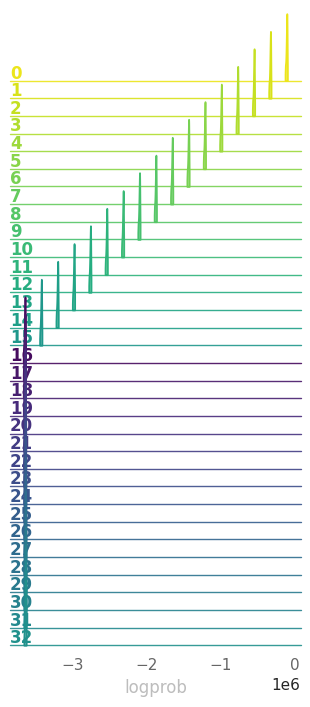

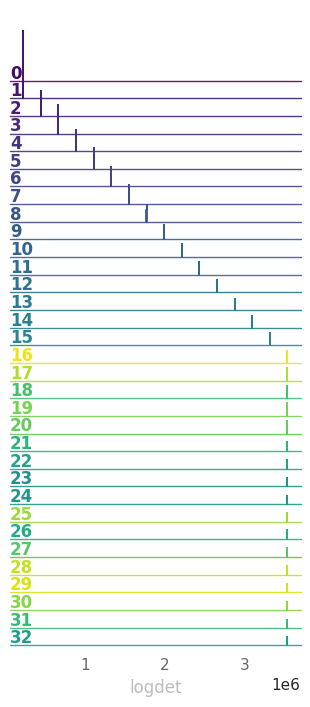

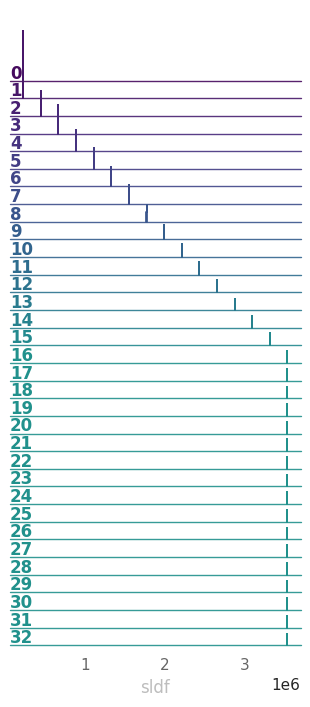

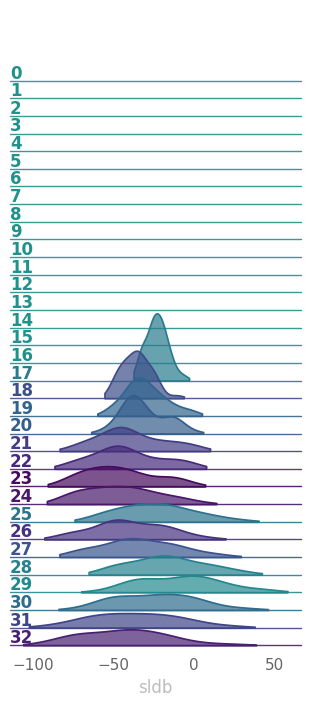

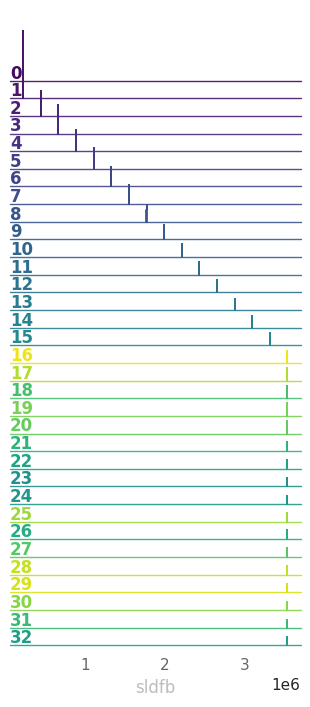

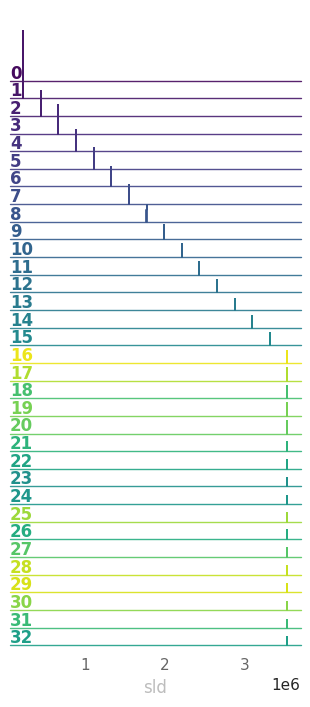

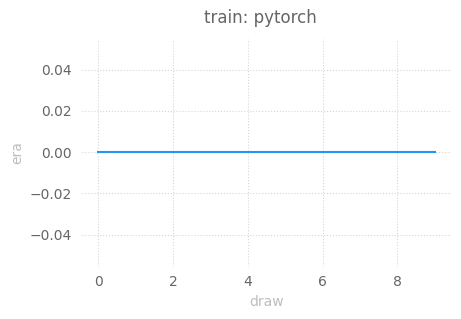

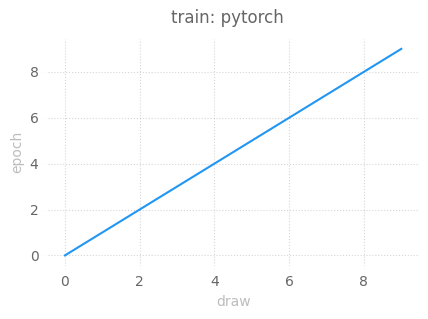

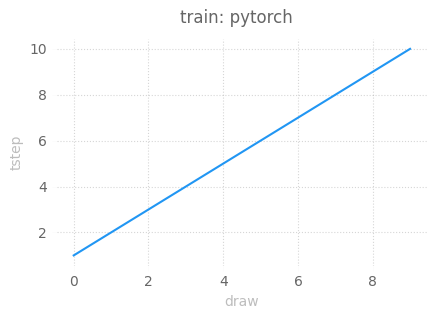

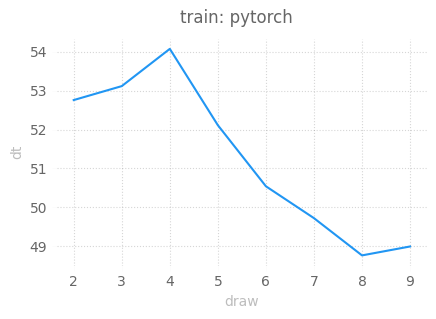

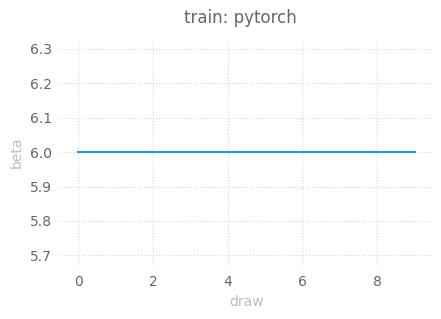

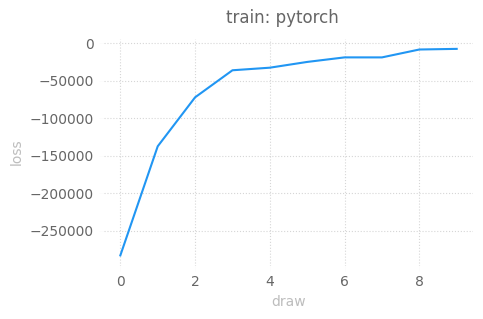

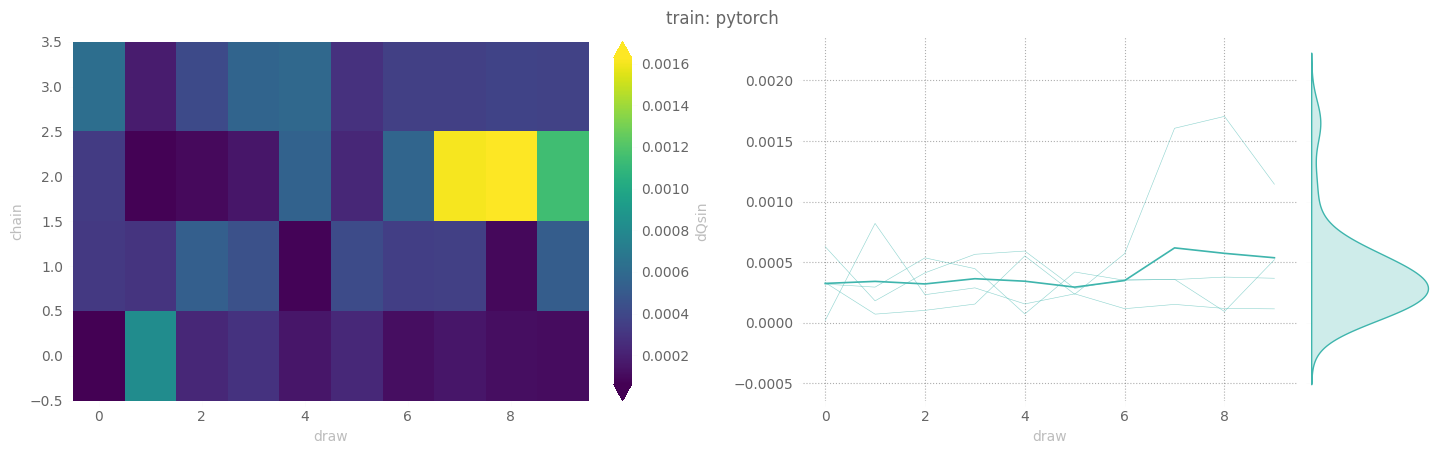

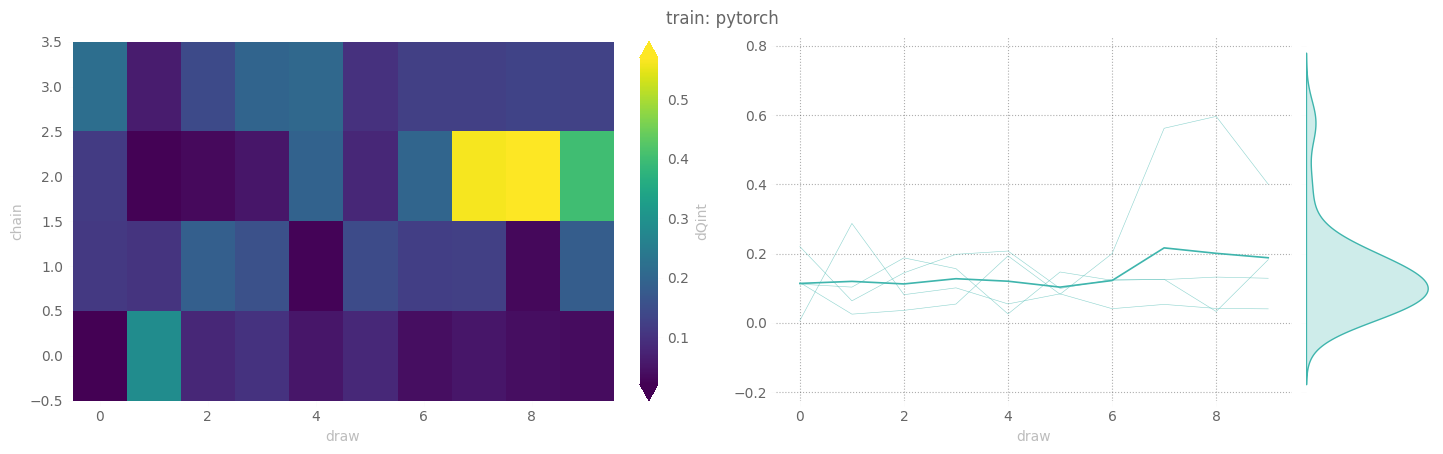

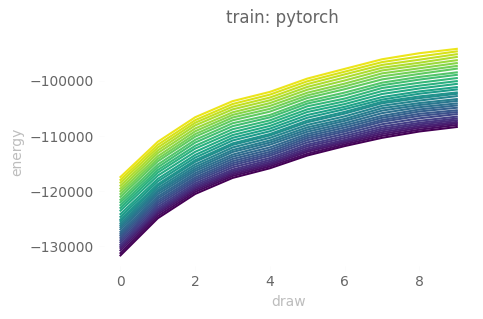

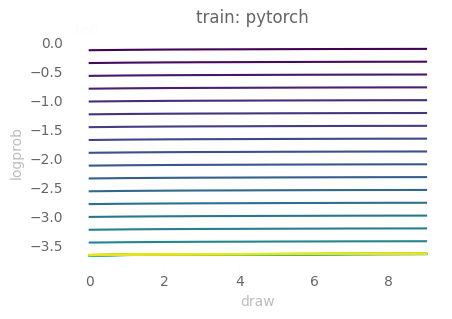

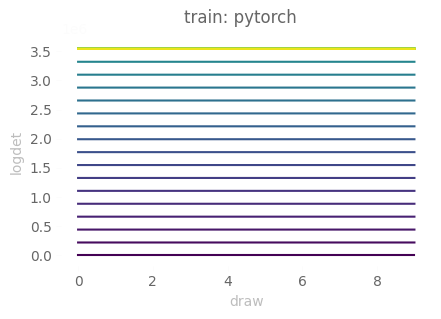

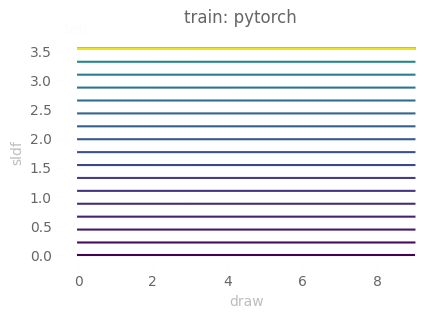

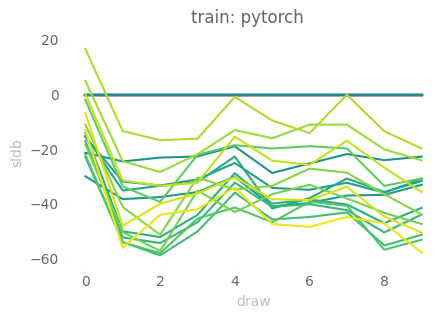

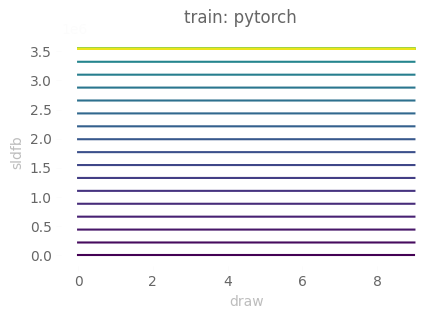

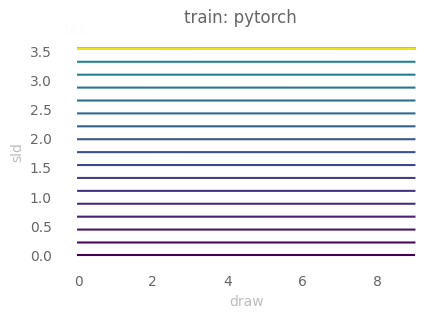

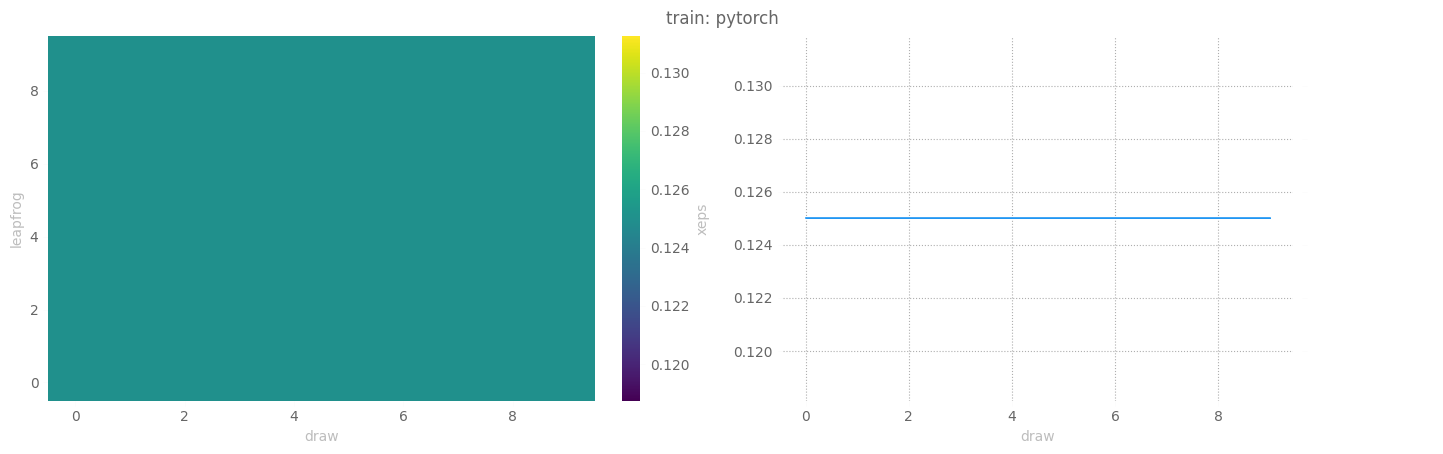

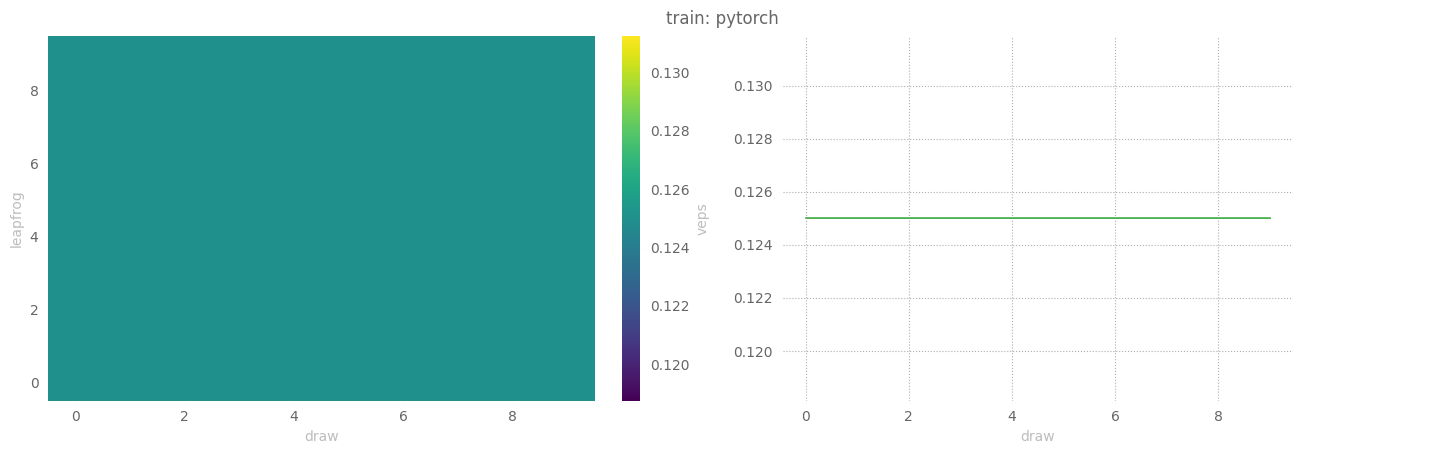

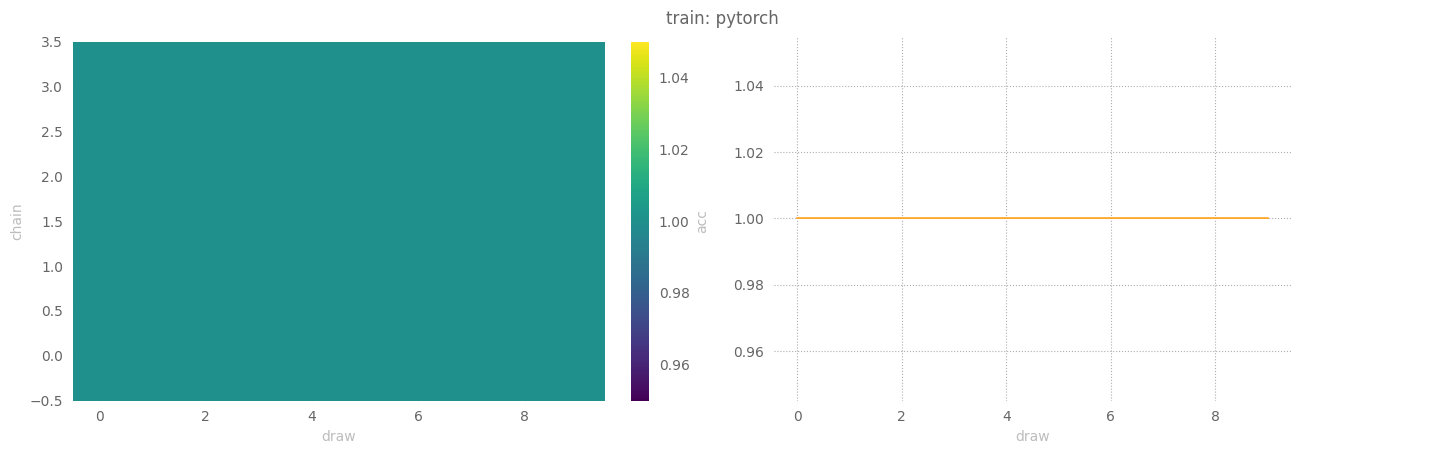

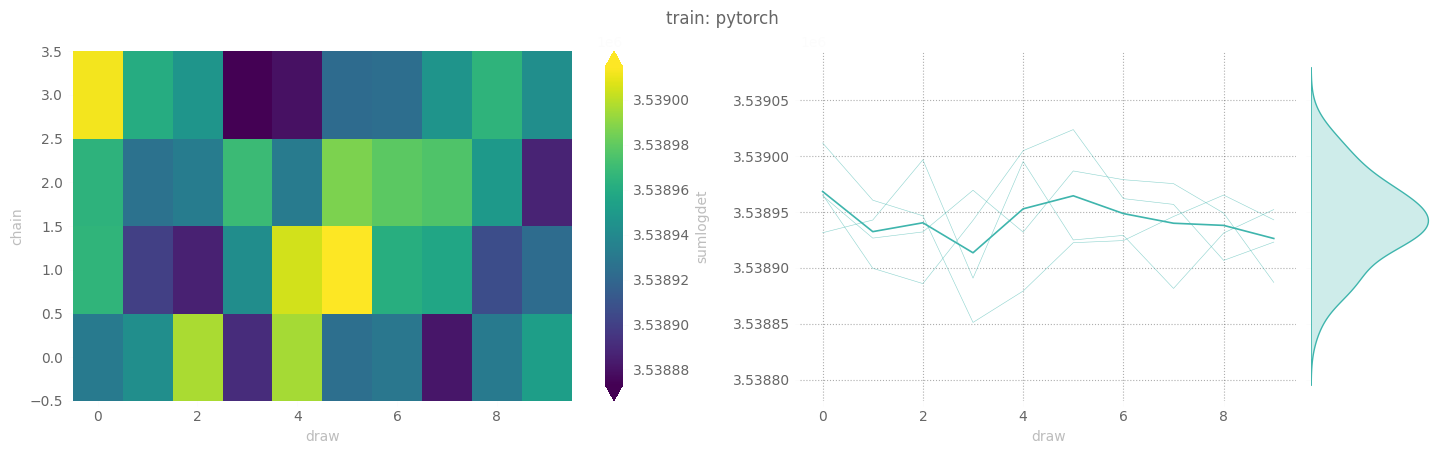

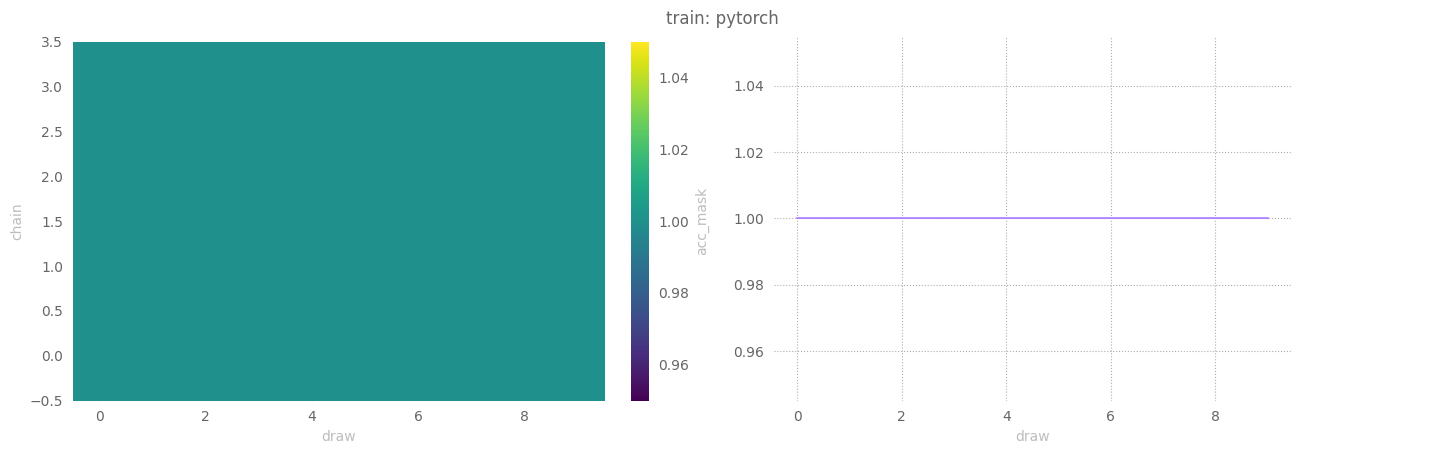

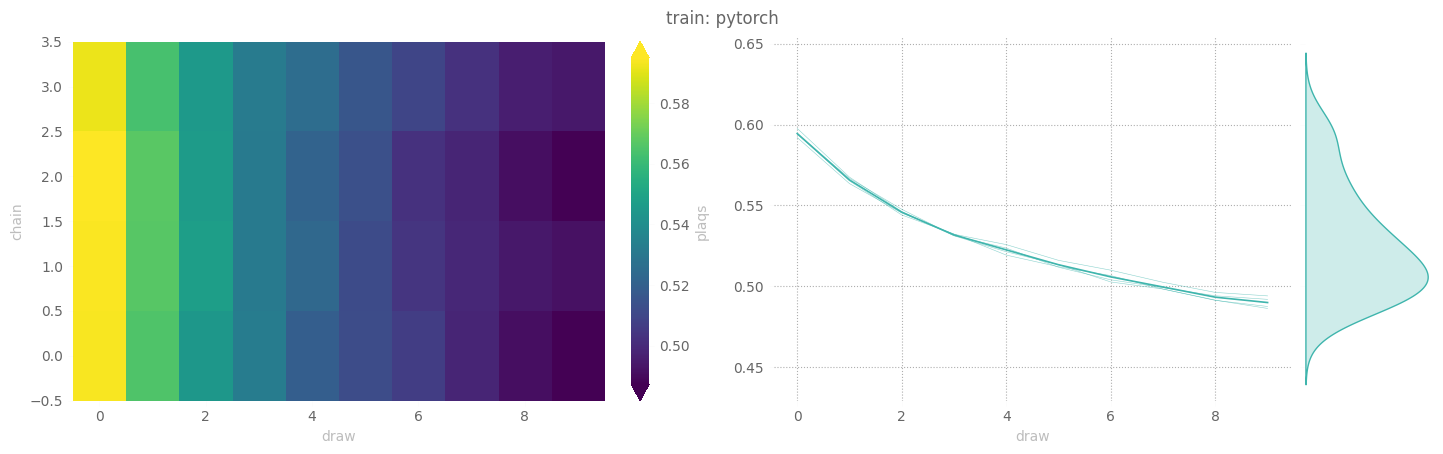

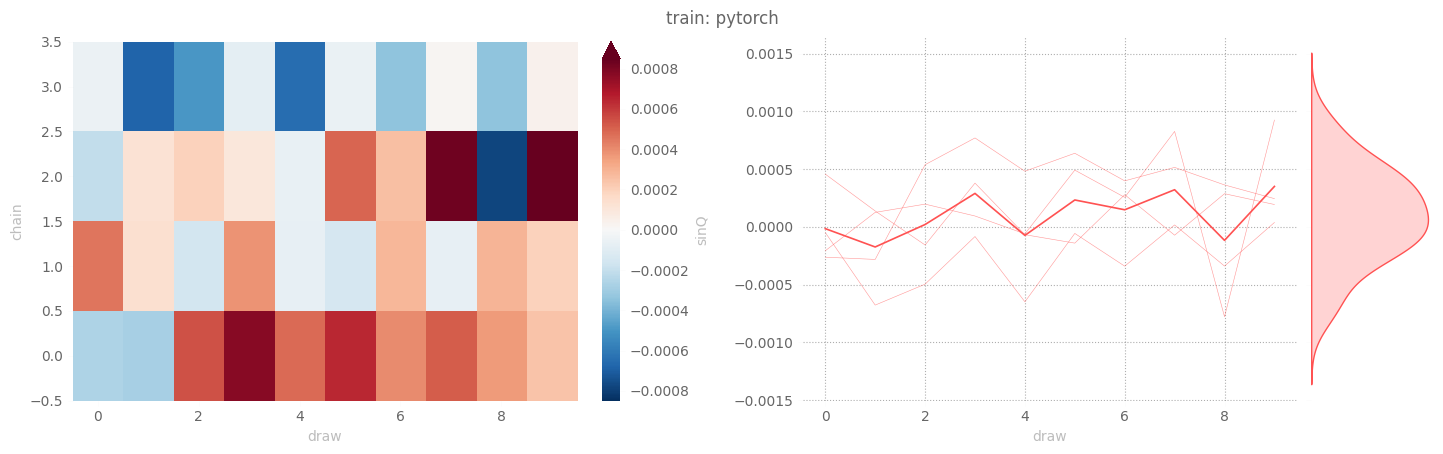

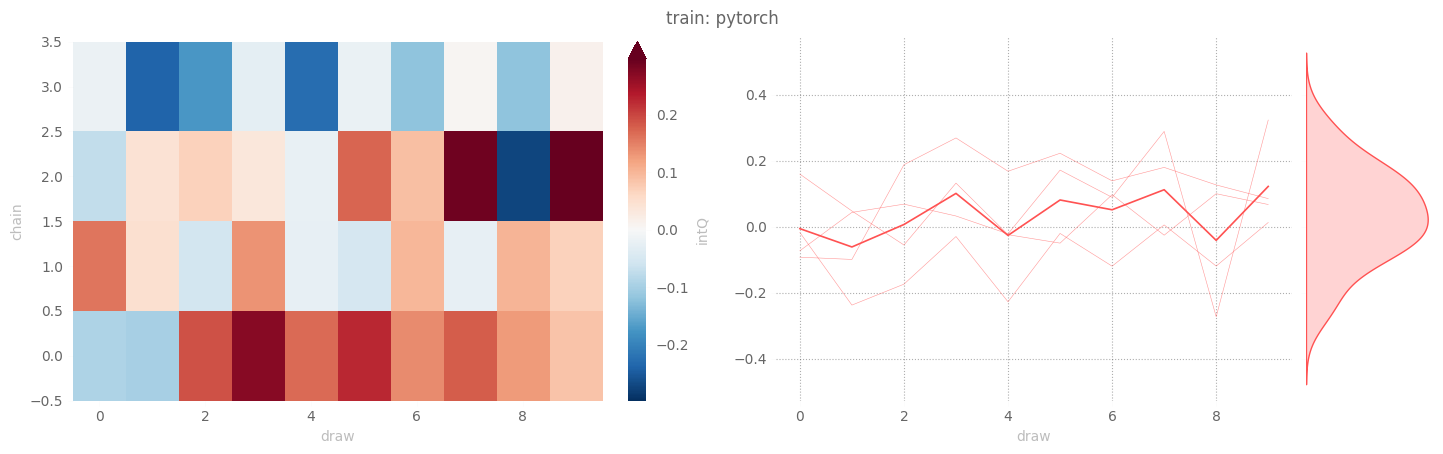

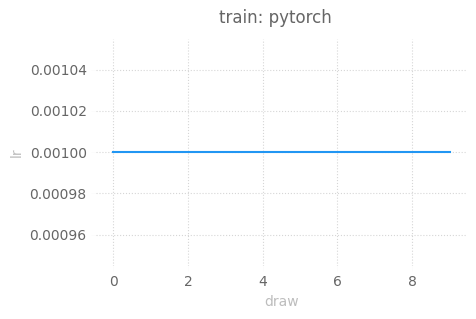

In [11]:
%matplotlib widget
import seaborn as sns
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

train_out = ptExpSU3.train(beta=6.0)

## Evaluation

[01:02:24] WARNING  x.shape (original): torch.Size([4, 4, 8, 8, 8, 12, 3, 3])

           INFO     eps=None                                                                                            
                    beta=6.0                                                                                            
                    nlog=1                                                                                              
                    table=<rich.table.Table object at 0x7f27c82fefd0>                                                   
                    nprint=1                                                                                            
                    eval_steps=100                                                                                      
                    nleapfrog=None

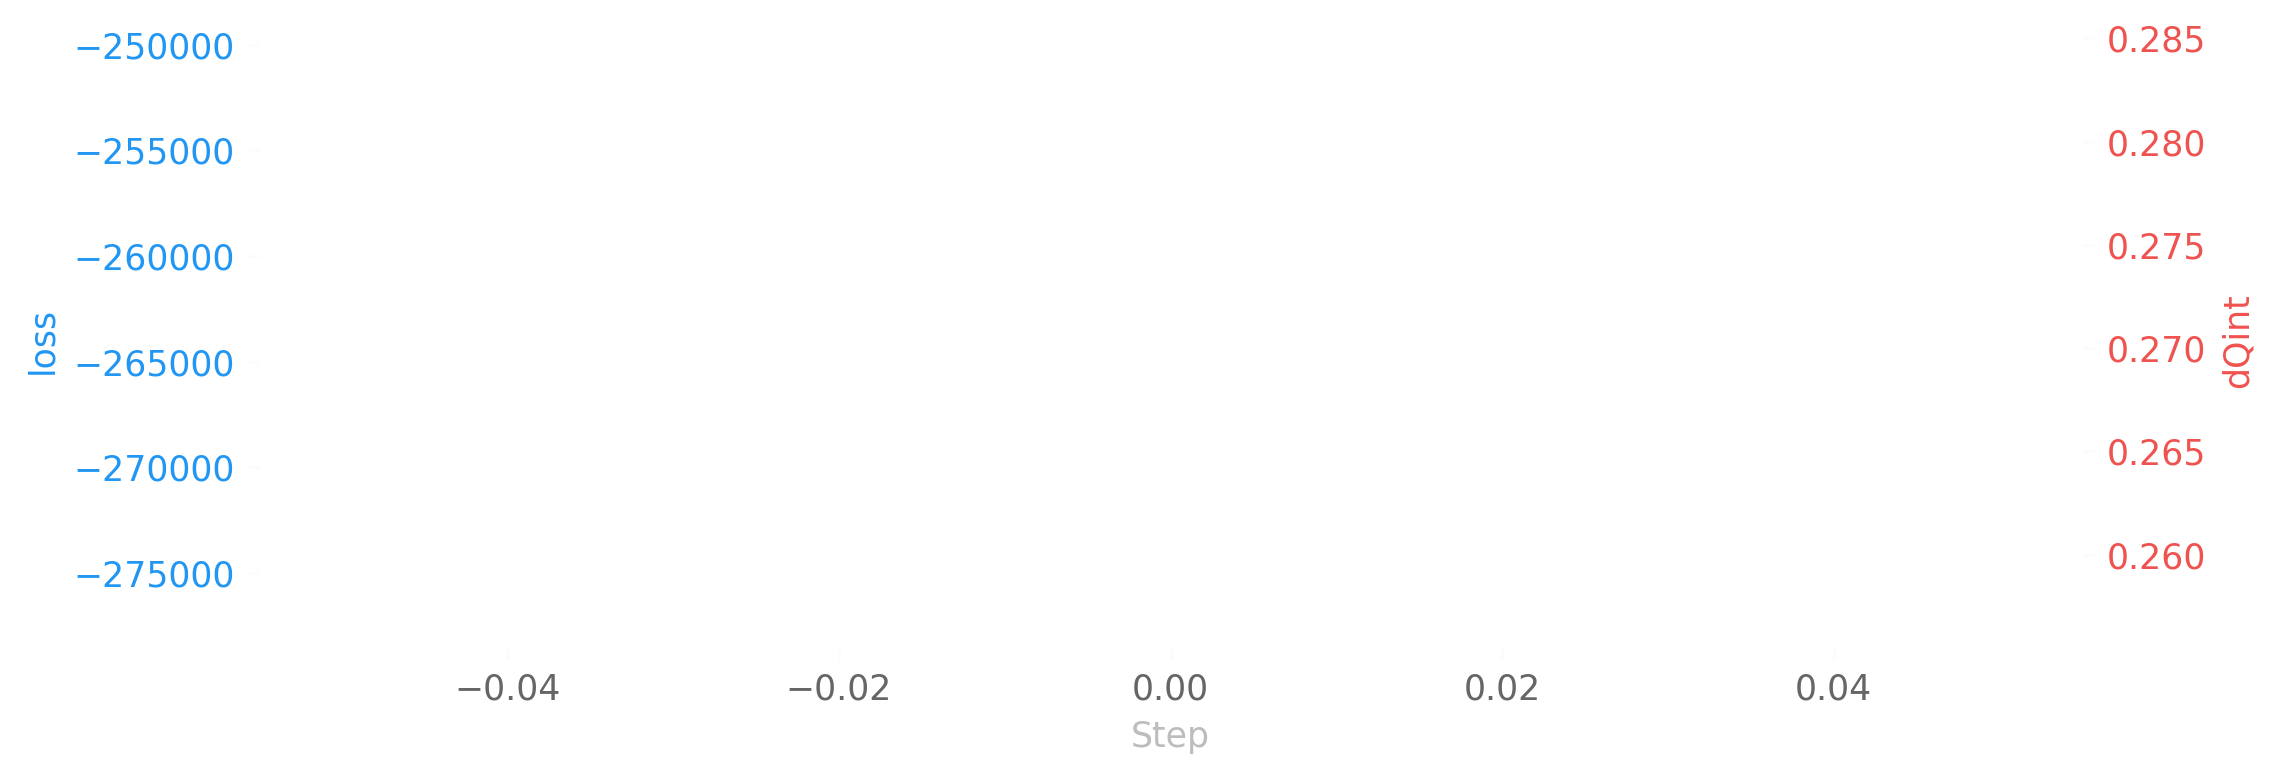

eval:   0%|          | 0/100 [00:00<?, ?it/s]

[01:02:47] INFO     estep=0   dt=40.0774 beta=6.0000 loss=-264007.4545 dQsin=0.0008 dQint=0.2704 energy=-124268.8362    
                    logprob=-2751670.7675 logdet=2627401.9313 sldf=2627410.9944 sldb=-9.0631 sldfb=2627401.9313         
                    sld=2627401.9313 xeps=0.1250 veps=0.1250 acc=1.0000 sumlogdet=3538936.0830 acc_mask=1.0000          
                    plaqs=0.5921 sinQ=0.0001 intQ=0.0218

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 79.35 GiB total capacity; 74.51 GiB already allocated; 21.19 MiB free; 77.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

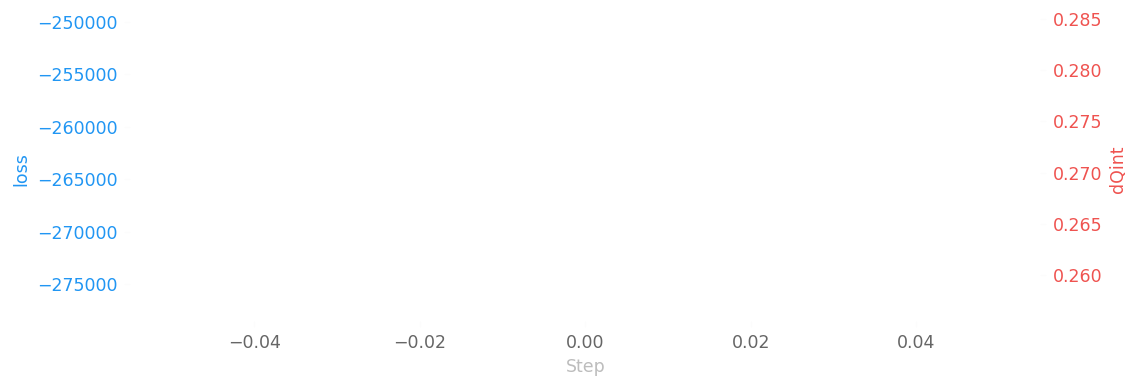

In [12]:
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

eval_out = ptExpSU3.evaluate(
    job_type='eval',
    beta=6.0,
    eval_steps=100,
    nprint=1,
)

## Generic HMC

[21:01:43] WARNING  x.shape (original): torch.Size([2, 4, 4, 4, 4, 8, 3, 3])

           INFO     eps=0.075                                                                                           
                    beta=6.0                                                                                            
                    nlog=1                                                                                              
                    table=<rich.table.Table object at 0x7f06b04d6910>                                                   
                    nprint=1                                                                                            
                    eval_steps=10                                                                                       
                    nleapfrog=16

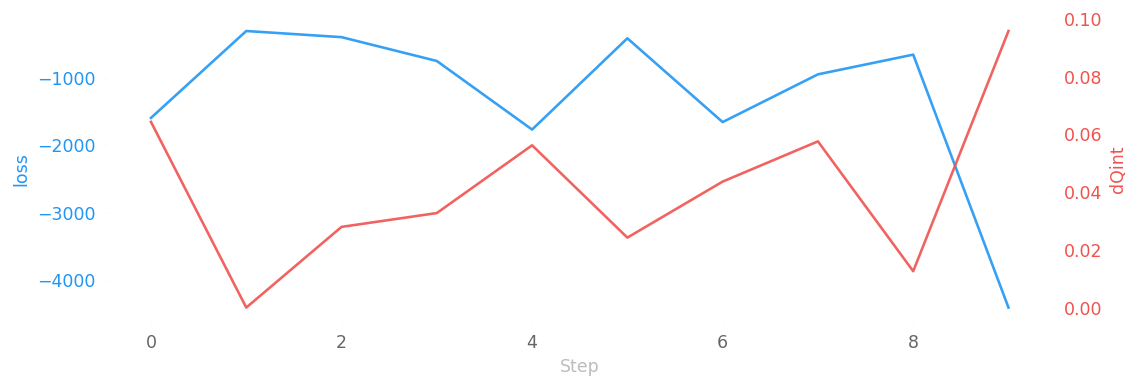

hmc:   0%|          | 0/10 [00:00<?, ?it/s]

[21:01:41] INFO     hstep=0   dt=0.2765 beta=6.0000 loss=-1595.8199 dQsin=0.0022 dQint=0.0643 energy=-10986.7014        
                    logprob=-10986.7014 logdet=0.0000 acc=0.6394 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5946          
                    sinQ=0.0011 intQ=0.0324

           INFO     hstep=1   dt=0.2832 beta=6.0000 loss=-308.8383 dQsin=0.0000 dQint=0.0000 energy=-10896.7842         
                    logprob=-10896.7842 logdet=0.0000 acc=0.1668 sumlogdet=0.0000 acc_mask=0.0000 plaqs=0.5945          
                    sinQ=-0.0011 intQ=-0.0319

[21:01:42] INFO     hstep=2   dt=0.2816 beta=6.0000 loss=-399.7182 dQsin=0.0010 dQint=0.0280 energy=-10928.2983         
                    logprob=-10928.2983 logdet=0.0000 acc=0.5581 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5945          
                    sinQ=-0.0011 intQ=-0.0319

           INFO     hstep=3   dt=0.2817 beta=6.0000 loss=-752.8123 dQsin=0.0011 dQint=0.0327 energy=-10905.8577         
                    logprob=-10905.8577 logdet=0.0000 acc=0.3171 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5918          
                    sinQ=-0.0001 intQ=-0.0040

[21:01:43] INFO     hstep=4   dt=0.2820 beta=6.0000 loss=-1768.3996 dQsin=0.0019 dQint=0.0562 energy=-10929.9866        
                    logprob=-10929.9866 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5909          
                    sinQ=-0.0002 intQ=-0.0049

[21:01:44] INFO     hstep=5   dt=0.2849 beta=6.0000 loss=-416.8979 dQsin=0.0008 dQint=0.0242 energy=-10892.6561         
                    logprob=-10892.6561 logdet=0.0000 acc=0.2657 sumlogdet=0.0000 acc_mask=0.5000 plaqs=0.5950          
                    sinQ=-0.0001 intQ=-0.0037

           INFO     hstep=6   dt=0.2839 beta=6.0000 loss=-1657.7146 dQsin=0.0015 dQint=0.0436 energy=-10894.7638        
                    logprob=-10894.7638 logdet=0.0000 acc=0.7422 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5936          
                    sinQ=-0.0010 intQ=-0.0279

[21:01:45] INFO     hstep=7   dt=0.2820 beta=6.0000 loss=-950.7159 dQsin=0.0020 dQint=0.0576 energy=-10825.9703         
                    logprob=-10825.9703 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5910          
                    sinQ=-0.0008 intQ=-0.0220

           INFO     hstep=8   dt=0.2828 beta=6.0000 loss=-658.6394 dQsin=0.0004 dQint=0.0126 energy=-10849.5365         
                    logprob=-10849.5365 logdet=0.0000 acc=0.3042 sumlogdet=0.0000 acc_mask=0.5000 plaqs=0.5916          
                    sinQ=0.0012 intQ=0.0356

[21:01:46] INFO     hstep=9   dt=0.2858 beta=6.0000 loss=-4404.7785 dQsin=0.0033 dQint=0.0958 energy=-10838.5193        
                    logprob=-10838.5193 logdet=0.0000 acc=1.0000 sumlogdet=0.0000 acc_mask=1.0000 plaqs=0.5888          
                    sinQ=0.0017 intQ=0.0482

[21:01:47] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/hmc/plots/ridgeplots/svgs/energy_ridgeplot.svg

[21:01:48] INFO     Ridgeplot for energy took 2.297s

[21:01:50] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/hmc/plots/ridgeplots/svgs/logprob_ridgeplot.svg

[21:01:51] INFO     Ridgeplot for logprob took 2.483s

[21:01:53] WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc
                    /notebooks/outputs/2023-01-26-212555/pytorch/hmc/plots/ridgeplots/svgs/logdet_ridgeplot.svg

[21:01:54] INFO     Ridgeplot for logdet took 2.855s

[21:01:01] INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hm
                    c/notebooks/outputs/2023-01-26-212555/pytorch/hmc/data/hmc_data.h5

           INFO     Done saving and analyzing data.

           INFO     Creating summaries for WandB, Aim

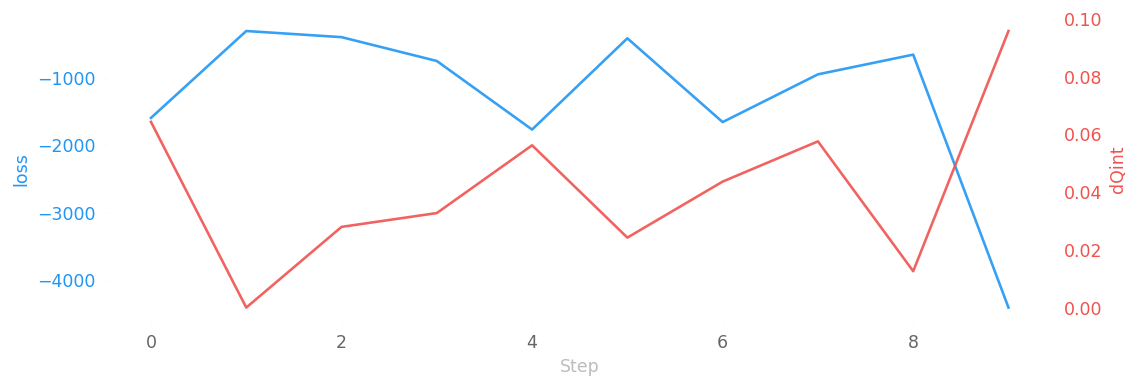

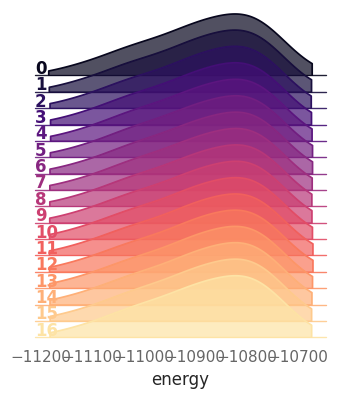

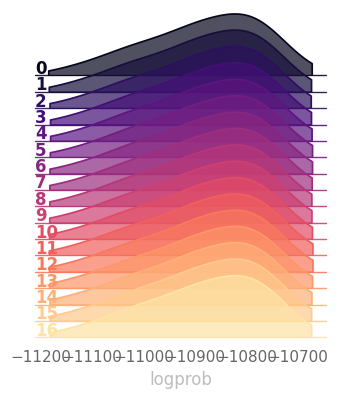

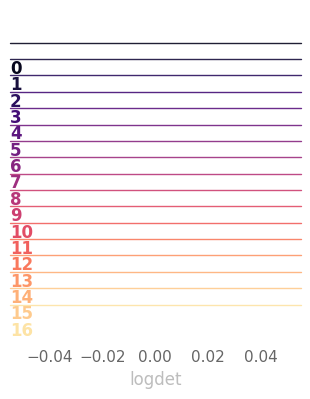

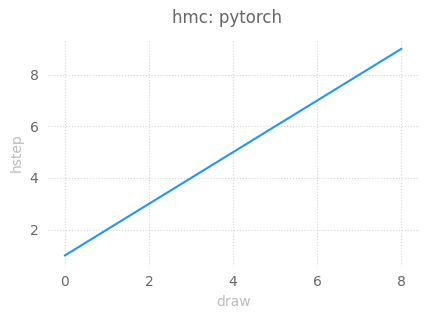

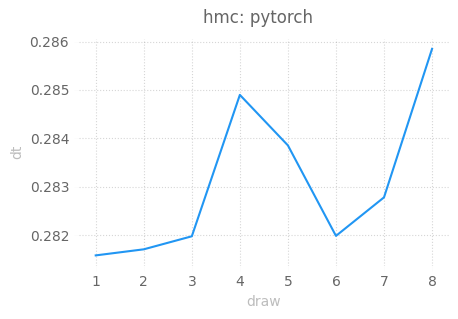

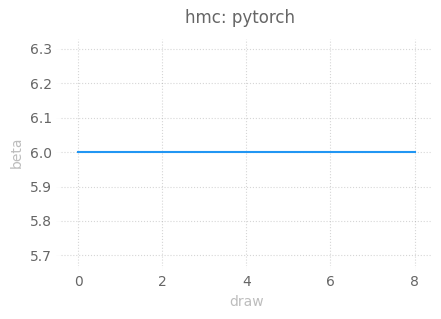

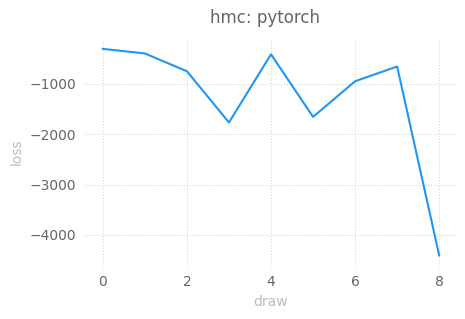

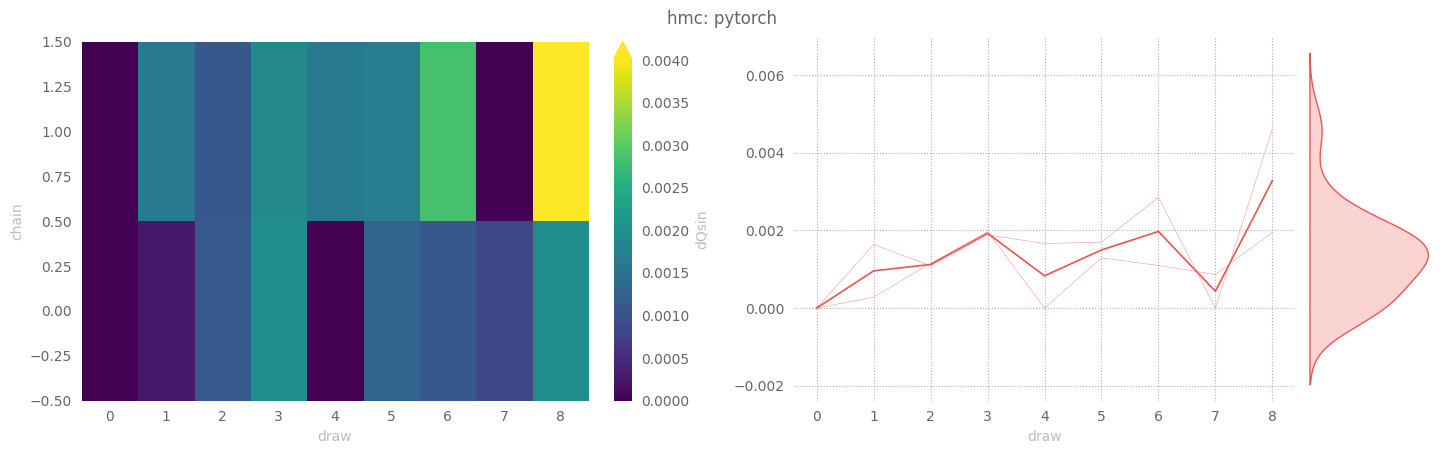

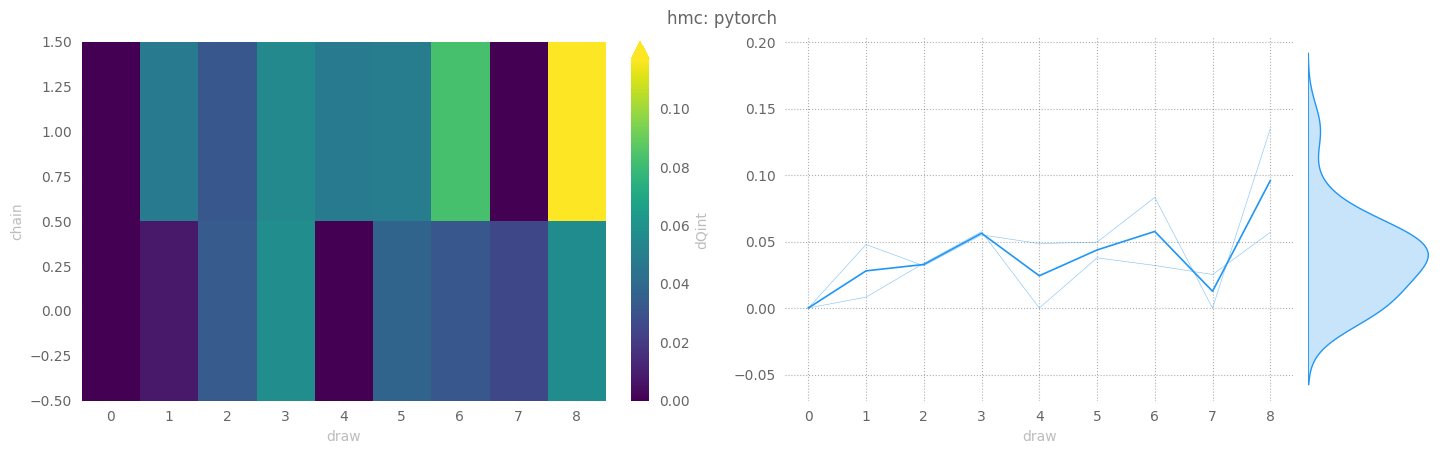

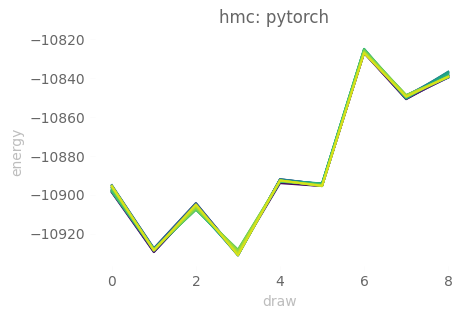

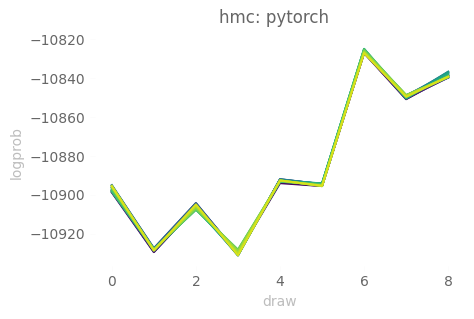

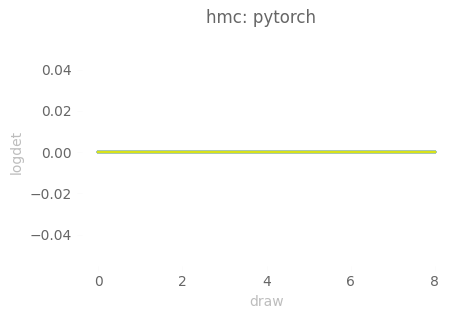

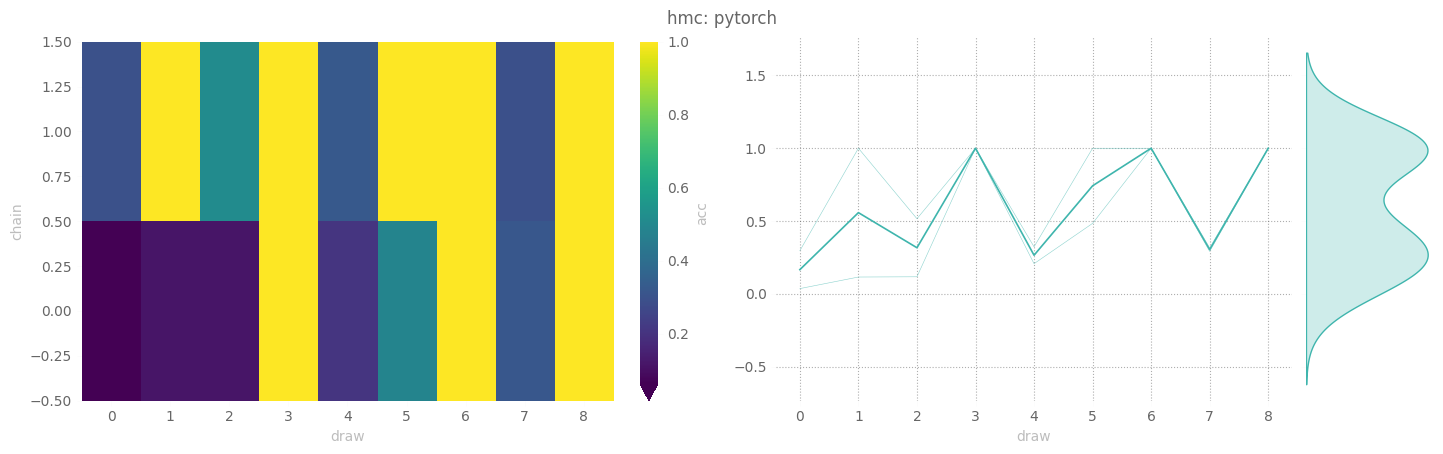

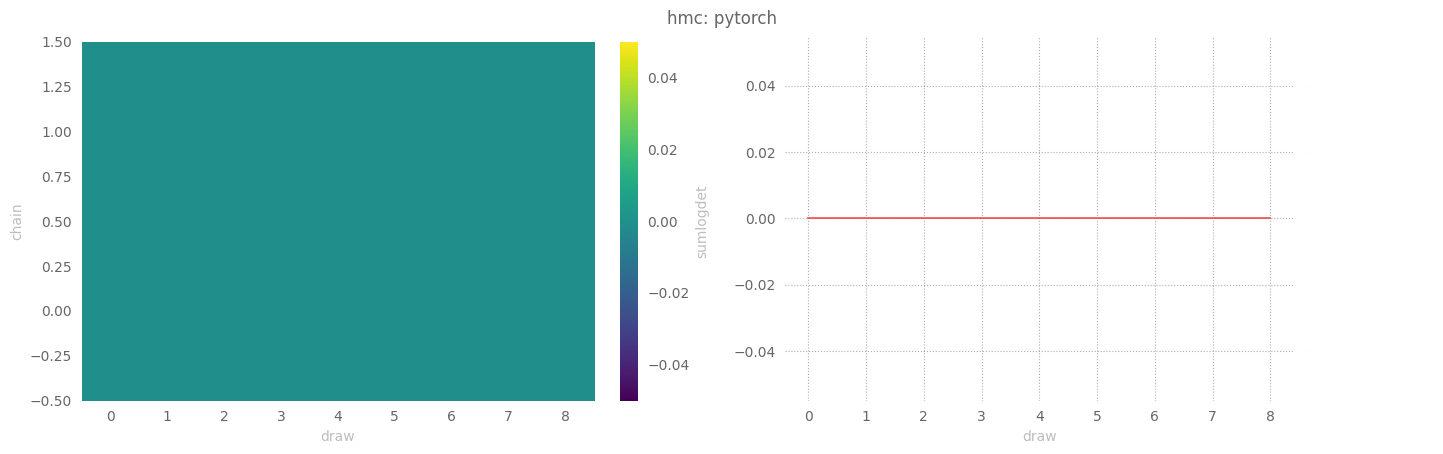

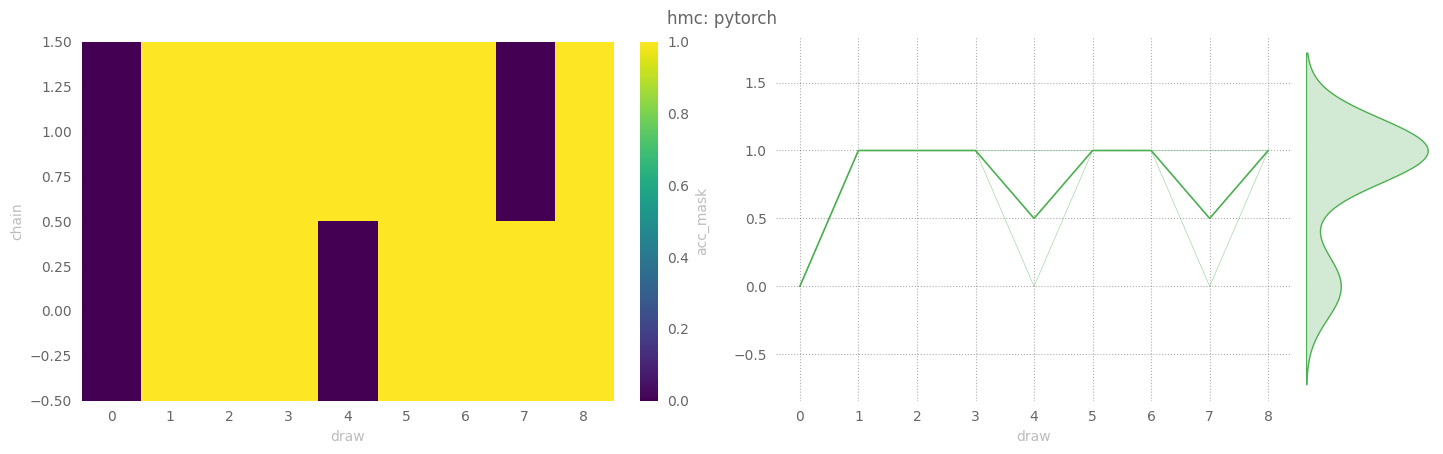

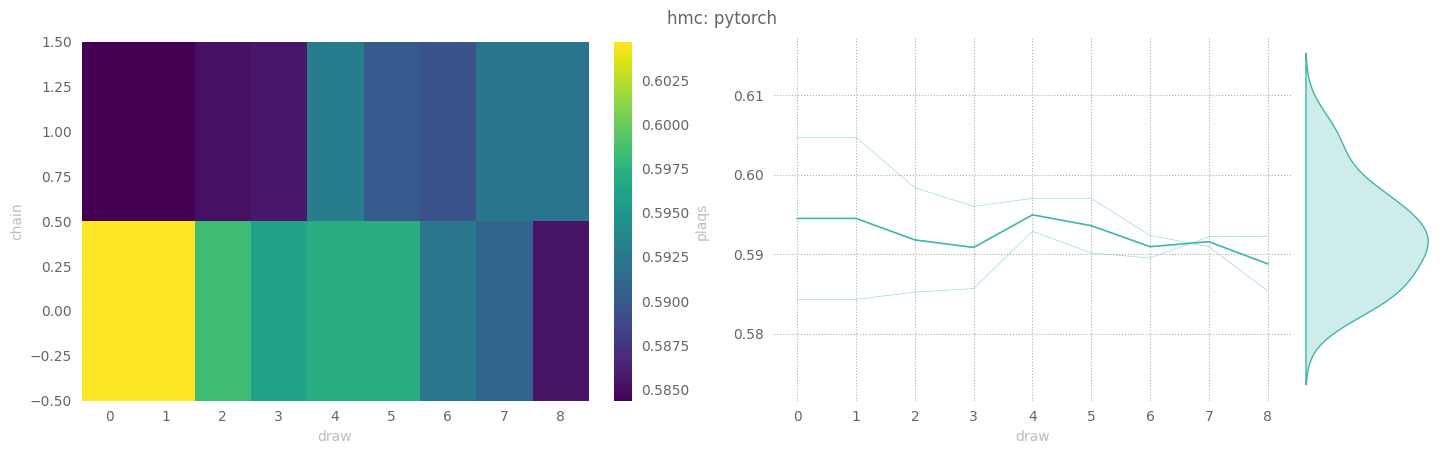

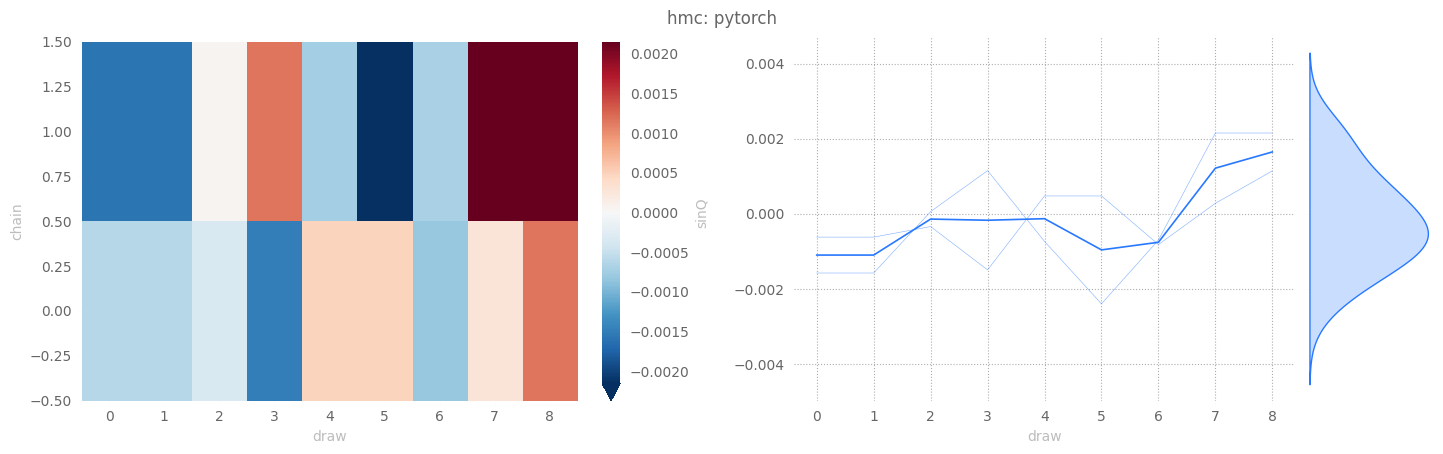

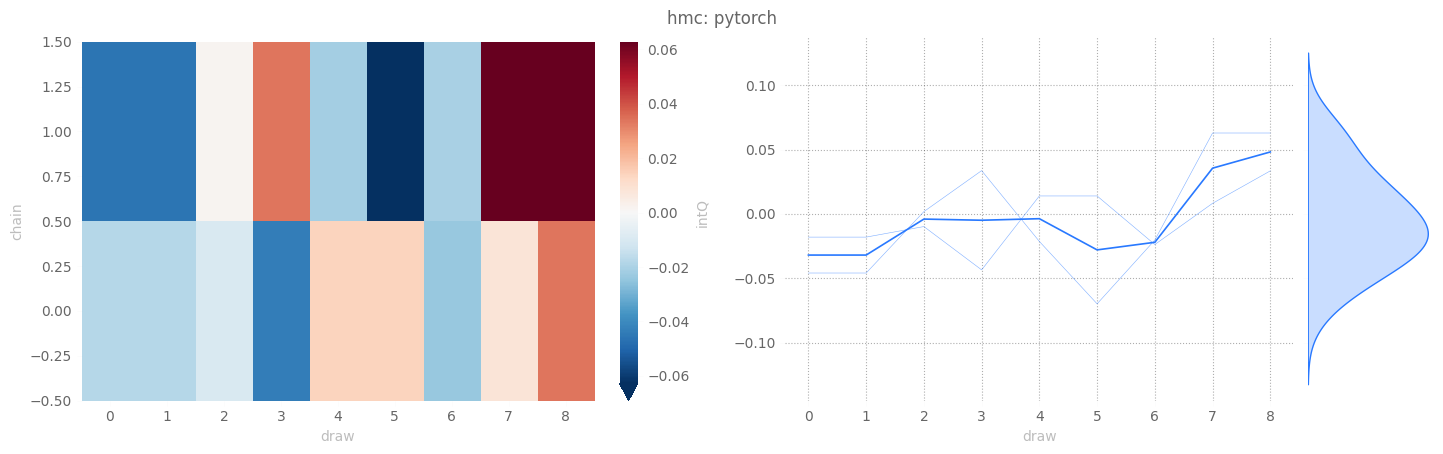

In [10]:
hmc_out = ptExpSU3.evaluate(
    job_type='hmc',
    beta=6.0,
    eval_steps=10,
    nprint=1,
    eps=0.075,
)